# Tutorial 3: Training a spiking neural network on a simple vision dataset

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

In Tutorial 2, we have seen how to train a simple multi-layer spiking neural network on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). However, the spiking activity in the hidden layer was not particularly plausible in a biological sense. Here we modify the network from this previous tutorial by adding activity regularizer, which encourages solutions with sparse spiking.

In [67]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [68]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs = 34 * 34
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-3
nb_steps  = 100

batch_size = 20

Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

## Data

In [69]:
## Load in the N-MNIST dataset
import tonic

train_dataset = tonic.datasets.NMNIST(save_to='./data', train=True, transform=None, target_transform=None)
test_dataset = tonic.datasets.NMNIST(save_to='./data', train=False, transform=None, target_transform=None)

In [70]:
import torch.nn.functional as F

def preprocess_spike_events(spike_events, nb_steps=nb_steps, nb_units=nb_inputs, time_step=time_step):
    """
    Convert spike events into a binned spike train.

    Args:
        spike_events: Structured NumPy array of spike events (x, y, t, p).
        nb_steps: Number of time steps to bin the spikes into.
        nb_units: Number of neurons (x * y resolution).

    Returns:
        A binned spike train of shape (nb_steps, nb_units).
    """
    spike_train = np.zeros((nb_steps, nb_units), dtype=np.float32)
    for x, y, t, p in spike_events:
        if p == 1:  # Only process the event if p indicates a spike
            time_bin = int(t * time_step)  # Convert time to timestep
            if time_bin < nb_steps:
                neuron_id = x + y * int(np.sqrt(nb_inputs))  # Flatten 2D coordinates into 1D neuron ID
                spike_train[time_bin, neuron_id] += 1

    return torch.tensor(spike_train, dtype=torch.float32)

In [71]:
def get_representative_subset_indices(data, limit, num_inputs = 10):
    """
    Selects a representative subset of data point indices for PyTorch Subset,
    using the number of unique labels as the number of representatives.

    Args:
        labels (np.ndarray or list): Array/list of labels for each data point.

    Returns:
        torch.Tensor: Tensor of indices of the selected representative data points.
    """

    num_representatives = len(data)  # Use number of unique labels

    representatives_per_class = num_representatives//num_inputs
    sample_per_class = limit // num_inputs
    selected_indices = []
    for i in range(num_inputs):
        range_v = np.arange(i*representatives_per_class, (i+1)*representatives_per_class)
        selected_indices.extend(np.random.choice(range_v, sample_per_class, replace=False))
        # selected_indices.append(np.random.choice(indices, 1, replace=False).item()) #ensure only one item is selected.

    return torch.tensor(selected_indices)


In [72]:
from torch.utils.data import DataLoader, Subset, TensorDataset

train_limit = 100
test_limit = 100
# train_dataset = test_dataset
train_subset_indices = get_representative_subset_indices(train_dataset, train_limit)
test_subset_indices = get_representative_subset_indices(test_dataset, test_limit)

train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_subset_indices)

train_x_data = torch.stack([preprocess_spike_events(sample, nb_steps, nb_units=nb_inputs) for sample, _ in train_subset])
train_y_tensor = torch.tensor([label for _, label in train_subset], dtype=torch.int64)  # Shape: (num_samples,)

train_data = TensorDataset(train_x_data, train_y_tensor)

test_x_data = torch.stack([preprocess_spike_events(sample, nb_steps, nb_units=nb_inputs) for sample, _ in test_subset])
test_y_tensor = torch.tensor([label for _, label in test_subset], dtype=torch.int64)  # Shape: (num_samples,)

test_data = TensorDataset(test_x_data, test_y_tensor)


train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=custom_collate_fn,  # Use the custom collate function
    # num_workers=4,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=custom_collate_fn,  # Use the custom collate function
    # num_workers=4,
    pin_memory=True,
    drop_last=True
)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# nb_steps = train_dataset[0][0].shape[0] # Get the number of time steps
# nb_inputs = 34 * 34

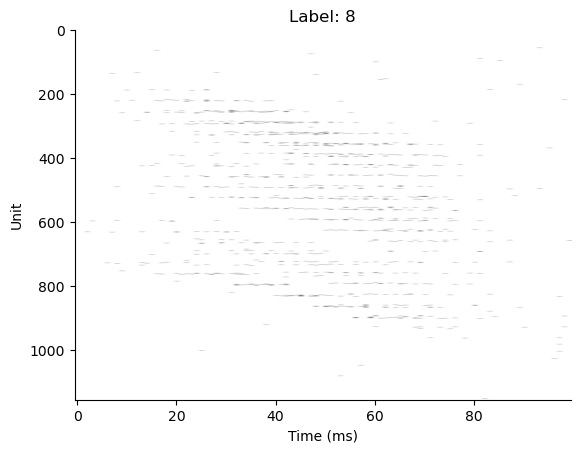

In [73]:
data_id = 80
plt.imshow(train_data[data_id][0].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.title(f"Label: {train_data[data_id][1]}")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

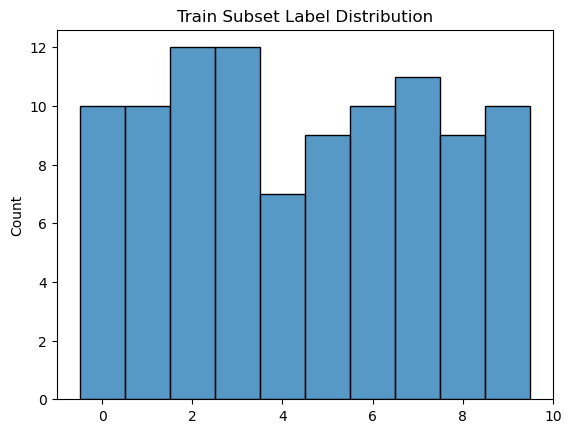

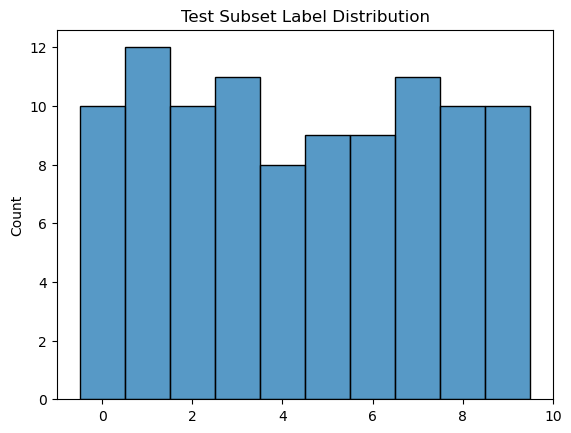

In [74]:
# Check distribution for each subset using train_loader.dataset[i][1]
train_labels = [int(train_loader.dataset[i][1]) for i in range(len(train_loader.dataset))]
test_labels = [int(test_loader.dataset[i][1]) for i in range(len(test_loader.dataset))]
sns.histplot(train_labels, discrete=True)
plt.title('Train Subset Label Distribution')
plt.show()
sns.histplot(test_labels, discrete=True)
plt.title('Test Subset Label Distribution')
plt.show()

### Setup of the spiking network model

In [75]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [76]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [77]:
weight_scale = 0.2

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [78]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

## Training the network

In [79]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [80]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [81]:
def train(data_loader, lr=1e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in data_loader:
            x_local = x_local.to(device)
            y_local = y_local.to(device)

            output,recs = run_snn(x_local.to_dense())
            _,spks=recs
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            
            # Here we set up our regularizer loss
            # The strength paramters here are merely a guess and there should be ample room for improvement by
            # tuning these paramters.
            reg_loss = 1e-5*torch.sum(spks) # L1 loss on total number of spikes
            reg_loss += 1e-5*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
            
            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        
from sklearn.metrics import confusion_matrix

def compute_classification_accuracy(data_loader):
    """ 
    Computes classification accuracy and confusion matrix on supplied data in batches.
    
    Returns:
        accuracy: Overall classification accuracy.
        conf_matrix: Confusion matrix of shape (num_classes, num_classes).
    """
    accs = []
    all_preds = []
    all_labels = []

    for x_local, y_local in data_loader:
        # Move data to the appropriate device
        x_local, y_local = x_local.to(device), y_local.to(device)

        # Run the SNN model
        output, _ = run_snn(x_local)

        # Compute predictions
        m, _ = torch.max(output, 1)  # Max over time
        _, preds = torch.max(m, 1)   # Argmax over output units

        # Compute accuracy for the current batch
        correct = (y_local == preds).float()  # Shape: [batch_size]
        tmp = correct.mean().item()  # Accuracy for the current batch
        accs.append(tmp)

        # Store predictions and labels for the confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_local.cpu().numpy())

    # Compute overall accuracy
    accuracy = np.mean(accs)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, conf_matrix

def plot_confusion_matrix(conf_matrix, class_names):
    """ Plots the confusion matrix. """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [82]:
loss_hist = train(train_loader, lr=2e-4, nb_epochs=30)

Epoch 1: loss=2.29145
Epoch 2: loss=2.24773
Epoch 3: loss=2.20306
Epoch 4: loss=2.16386
Epoch 5: loss=2.10842
Epoch 6: loss=2.05684
Epoch 7: loss=1.99654
Epoch 8: loss=1.92822
Epoch 9: loss=1.86786
Epoch 10: loss=1.79810
Epoch 11: loss=1.72170
Epoch 12: loss=1.64996
Epoch 13: loss=1.58677
Epoch 14: loss=1.53097
Epoch 15: loss=1.45830
Epoch 16: loss=1.39184
Epoch 17: loss=1.33356
Epoch 18: loss=1.27427
Epoch 19: loss=1.21535
Epoch 20: loss=1.17141
Epoch 21: loss=1.12469
Epoch 22: loss=1.07979
Epoch 23: loss=1.03486
Epoch 24: loss=0.98849
Epoch 25: loss=0.95464
Epoch 26: loss=0.91304
Epoch 27: loss=0.88253
Epoch 28: loss=0.84990
Epoch 29: loss=0.81642
Epoch 30: loss=0.78573


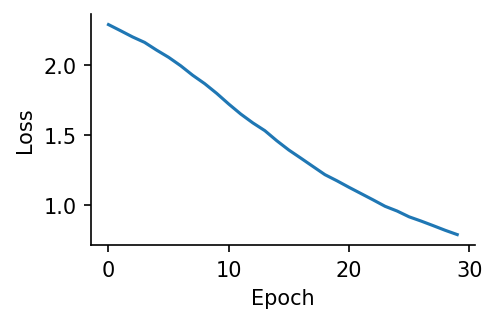

In [83]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

Train Accuracy: 92.00%


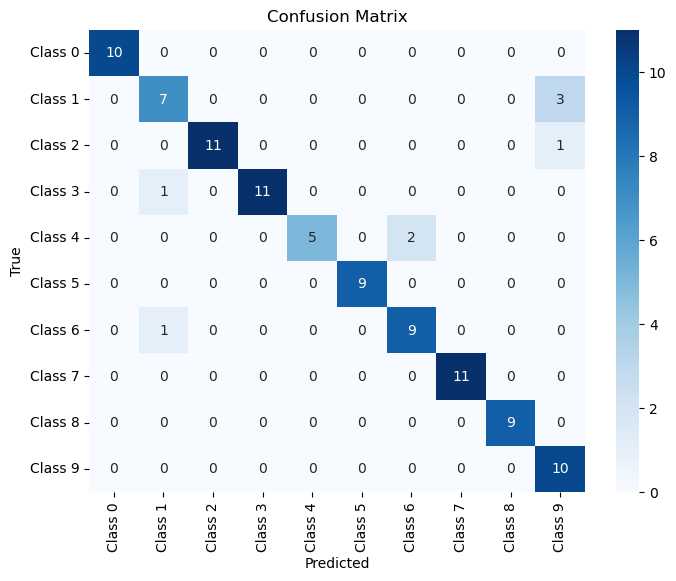

In [84]:
train_accuracy, train_conf_matrix = compute_classification_accuracy(train_loader)

# Print results
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(train_conf_matrix, class_names)


Test Accuracy: 67.00%


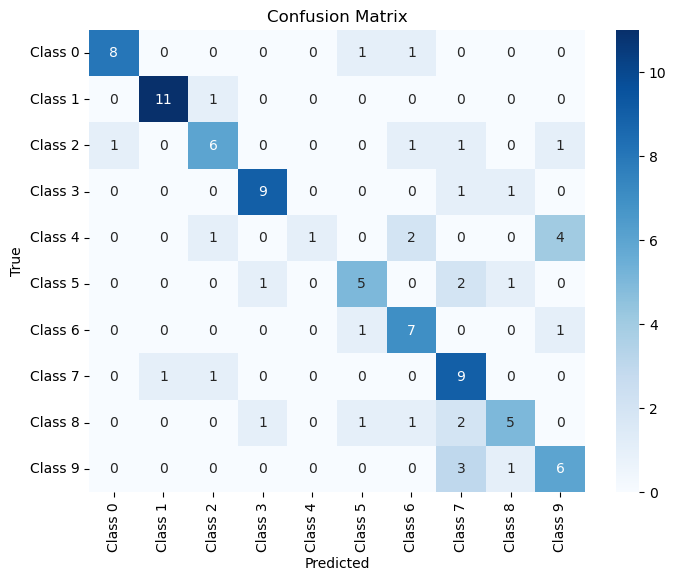

In [85]:
test_accuracy, test_conf_matrix = compute_classification_accuracy(test_loader)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(test_conf_matrix, class_names)


In [86]:
def get_mini_batch(data_loader, shuffle=False):
    for ret in data_loader:
        return ret

In [87]:
x_batch, y_batch = get_mini_batch(test_loader)
x_batch = x_batch.to(device)
output, other_recordings = run_snn(x_batch)
mem_rec, spk_rec = other_recordings

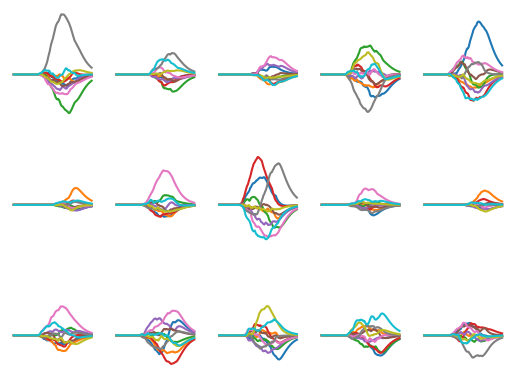

In [88]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

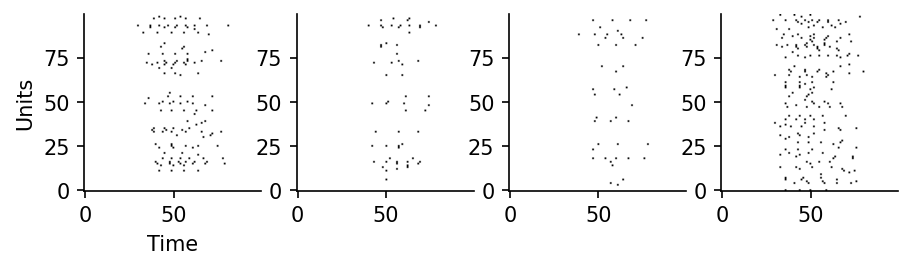

In [89]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

Compared to the hidden layer activity in our previous Tutorial 2, we can now appreciate that spiking in the hidden layer is much sparser.

In the next tutorial notebook, we will apply the same training paradigm to the Heidelberg Digits, a realistic speech dataset generated from spoken digits processed through a plausible cochlea model.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.